TP2 Produits Dérivés

Equipe : 
Harold Herbert Nonguierma - 11229979 
Idriss Wanassy  - 11237451
Yissan  Yaro - 11222222

Import des librairies 

In [473]:
import numpy as np
import scipy
from scipy import sparse
from scipy import linalg
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import splu
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as opt
from scipy import optimize
import pandas

In [ ]:
Définition des fonctions à utiliser

In [474]:
##Fonction pour l'approximation de la frontière par CJM

def m(r,sigma,tau):
    def mfunc(m):
        def erf(x):
            return 2*norm.cdf(x*np.sqrt(x))-1
        def beta(tau):
            return 0.75*sigma-0.5*r/sigma + 0.5*m/(2*np.sqrt(tau))
        
        return sigma*np.exp(-(r +0.5*sigma**2)*tau-sigma*np.sqrt(tau)*m)*norm.cdf(-m) -r*(erf(np.sqrt(r+0.5*beta(tau)**2)*tau))/(np.sqrt(2*r+beta(tau)**2))
    return optimize.brentq(mfunc,0.0001,100,maxiter=1000)    




def Bt(K,r,sigma,tau):
    return K*np.exp(-(r+0.5*sigma**2)*tau -sigma*np.sqrt(tau)*m(r,sigma,tau))

##Fonction Black-Scholes
def BS(S,K,T,vol,r,t):
    d1= (np.log(S/K)+T*(r + 0.5*vol**2))/(vol*np.sqrt(T))
    d2= d1 - vol*np.sqrt(T)
    if t =="c":
        p = (S*norm.cdf(d1) - K*norm.cdf(d2)*np.exp(-r*T))
    elif t == "p" :
        p = (K*norm.cdf(-d2)*np.exp(-r*T) - S*norm.cdf(-d1))
    return p

# Fonction pour le gamma BS
def gammaBS(S,K,T,vol,r):
    d1= (np.log(S/K)+T*(r + 0.5*vol**2))/(vol*np.sqrt(T))    
    return norm.pdf(d1)/(S*vol*np.sqrt(T))




Question 1
Pour le put up and out, le Smax doit etre de 110 car toutes les valeurs supérieures ou égales seront de zéro.

Question 2 - Fonction Crank-Nicolson

Nous avons codé notre fonction de sorte à pouvoir évaluer le prix d'un put barrière meme si le S_max utilisé est supérieur à la barrière. La résolution du système d'équation à chaque pas de temps est faite par décomposition LU de matric sparse.

In [ ]:
def CrankNicolson(I,K,Smax,T,SK,r,sigma,exercise,bar =0):

    grid = np.linspace(0,Smax,I+1)[::-1] # vecteur unidimensionel des prix de l'action, a etre utiliser a chaque pas de temps
    dS = Smax/I # pas d'actif
    dT = T/K #pas de temps
    v1 = dT/(dS**2)
    v2 = dT/dS
    
    #condition pour options vanilles
    
    if bar == 0:
        
        
        
        putgrid = np.zeros((I+1,K+1)) #initialisation de la grille entière des prix du put
        putgrid[I,] = [SK*np.exp(-r*i*dT) for i in range(K+1)] #condition terminale pour I = 0
        putgrid[:,K] = [max(0,SK-grid[i]) for i in range(I+1)]# condition terminale au dernier pas de temps
        
        #Calcul des coeeficients a,b,c,A,B,C,alpha,beta,gamma
        a = 0.5*(sigma**2)*(grid**2)
        b = r*grid
        A = v1*a-0.5*b*v2
        B = -2*v1*a - dT*r + 2
        C = v1*a + 0.5*b*v2
        alpha = -v1*a + 0.5*b*v2
        beta = 2*v1*a + dT*r +2
        gamma = -v1*a - 0.5*b*v2
        
        #construction de la matrice des coefficients alpha, beta et gamma
        matcoeff = np.zeros((I-1,3))
        for i in range(0,I-1):
            matcoeff[i,] = np.concatenate((np.array([gamma[i+1]]),np.array([beta[i+1]]),np.array([alpha[i+1]])),axis = 0)

        #transformation de la matrice des coefficients en matrice tridiagonale
        F = max(I,K)-max(0,K-I)
        newval = np.zeros((I-1,F+1))
        for i in range(0,I-1):
            newval[i,][i:i+3] = matcoeff[i,]
            
            #suppression des coefficients qui multiplient les noeuds terminaux, vu que ceux-ci sont déja connus
        mat = np.delete(newval,[0,F], axis = 1)
        
        #stockage de la matrice en tant que matrice sparse, afin d'accélérer la résolution
        matsp = csc_matrix(mat)
        
        #boucle de remplissage de la grille des put : le systeme sera résolu a chaque noeud temporel pour les K noeuds
        for s in range(0,K):
            
            h =np.zeros((I-1))
            
            for i in range(1,I):
                j= i-1
                h[j] = C[i]*putgrid[i-1,K-s] + B[i]*putgrid[i,K-s] + A[i]*putgrid[i+1,K-s] #vecteur des valeurs h obtenues par combinaison linéaire des valeurs d'option du pas de temps actuel
            
            
            h[0] = h[0] - newval[0,0]*putgrid[0,K-s] 
            h[I-2] = h[I-2] - newval[I-2,F]*putgrid[I,K-s]
            
            
                #si l'option est européenne
            if exercise == "e":
                putgrid[1:I,K-1-s]= (scipy.sparse.linalg.splu(matsp).solve(h)) #résolution du système par inversion et décomposition LU de la matrice sparse
                #putgrid[putgrid<0] = 0
                result = putgrid
                
                #si l'option est américaine
            elif exercise == "a":
                pay = np.maximum(0,SK-grid)
            
                putgrid[1:I,K-1-s]= np.maximum((scipy.sparse.linalg.splu(matsp).solve(h)),pay[1:I]) #résolution du système par inversion et décomposition LU de la matrice sparse
                
                
                diff = putgrid - pay[:,None]
                
                #estimation de la frontiere d'exercice a chaque pas de temps, en trouvant pour chaque pas de temps la première valeur de S pour laquelle il est optimal d'exercer
                EB = np.flip([grid[diff[:,i]==0][1] for i in range(0,K)])

                
                result = putgrid , EB
        
    #meme exercice, pour une option barrière. La fonction est codée de sorte a fonctionner quelque soit la combinaison S-max et de barrière utilisée pour la grille.Elle fonctionnera mme pour S > B
    elif bar !=0:
    
        #réduction de la dimension verticale de la grille pour la limiter à un noeud au-dessus de la barrière, vu que toute les valeurs au-dessus de cette dernière sont nulles
        #nous conservons cependant le meme pas de temps
        grid= grid[grid<=np.ceil(bar/dS)*dS]
        I = len(grid) -1
        
        
        putgrid = np.zeros((I+1,K+1))
        putgrid[I,] = [SK*np.exp(-r*i*dT) for i in range(K+1)]
        putgrid[:,K] = [max(0,SK-grid[i]) for i in range(I+1)]
        a = 0.5*(sigma**2)*(grid**2)
        b = r*grid
        A = v1*a-0.5*b*v2
        B = -2*v1*a - dT*r + 2
        C = v1*a + 0.5*b*v2
        alpha = -v1*a + 0.5*b*v2
        beta = 2*v1*a + dT*r +2
        gamma = -v1*a - 0.5*b*v2
        
        
        matcoeff = np.zeros((I-1,3))
        for i in range(0,I-1):
            matcoeff[i,] = np.concatenate((np.array([gamma[i+1]]),np.array([beta[i+1]]),np.array([alpha[i+1]])),axis = 0)

        
        F = max(I,K)-max(0,K-I)
        newval = np.zeros((I-1,F+1))
        for i in range(0,I-1):
            newval[i,][i:i+3] = matcoeff[i,]
            
            
        mat = np.delete(newval,[0,F], axis = 1)
        
        matsp = csc_matrix(mat)
        
        for s in range(0,K):
            
            h =np.zeros((I-1))
            
            for i in range(1,I):
                j= i-1
                h[j] = C[i]*putgrid[i-1,K-s] + B[i]*putgrid[i,K-s] + A[i]*putgrid[i+1,K-s]
            
            
            h[0] = h[0] - newval[0,0]*putgrid[0,K-s]
            h[I-2] = h[I-2] - newval[I-2,F]*putgrid[I,K-s]
            
            if exercise == "e":
                putgrid[1:I,K-1-s]= scipy.sparse.linalg.splu(matsp).solve(h)
        
                result = putgrid
            elif exercise == "a":
                pay = np.maximum(0,SK-grid)
            
                putgrid[1:I,K-1-s]= np.maximum((scipy.sparse.linalg.splu(matsp).solve(h)),pay[1:I])
                
            
                diff = putgrid - pay[:,None]
                

                EB = np.flip([grid[diff[:,i]==0][1] for i in range(0,K)])

                
                result = putgrid , EB
            
    return  result



Définition des variables du TP

In [476]:
S_TP = 100
SK_TP = 100
bar_TP = 110
T_TP = 1
sigma_TP = 0.25
r_TP =0.05
Smax = 200
I = 5000
K = 3650
I_bar = 2750
dS = Smax/I
S0 = np.linspace(0,Smax,I+1)[::-1] # vecteur de prix du sous-jaccent

zz = len(S0[S0>=np.ceil(bar_TP/dS)*dS]) - 1

Question 3

Nous avons choisi d'interpréter la figure pour laquelle tous les puts ont été pricé avec une grille de 5000 pas d'actifs, afin de maximiser la précision. La première chose que nous remarquons ici est que, pour  la trajectoire du put européen obtenu par Black-Scholes(bleu) est indisguingable de celle du put européen pricé par Crank-Nicolson(en orabge). Egalement, toute les trajectoires sauf celle de l'option européenne évaluée par Crank-Nicolson se confondent avec la ligne d'exercice (en violet), jusqu'aux alentours de S = 87.5 ou elles se dissocient toutes. Le put européen évalué par Crank-Nicolson(orange) garde une valeur toujours inférieure aux autres pour S<87.5, puis commence à ce confondre avec le put CN américain (en vert), un peu après S = K. On remarque également qu'à mesure qu'on s'approche du strike, tout les put(exepté le put barrière) manifestent beaucoup plus de convexité, surtout le put CN américain. Le put Barrière devient nul à partir de S = 110. Le put européen croise la ligne d'exercice à S = 87.5.Enfin, il est intéréssant de noter que le put américain vanille manifeste plus de convexité que ses contreparties européennes. La figure ci-dessous fait un zoom du graph précédent sur la région entre S = 75 et S = 125 nous aide a mieux observer ces distinctions.

In [528]:
#Evaluation des  puts européens, américains, et barrière américains par Crank-Nicolson et par Black-Scholes pour le put européen

BS_euro = [BS(i,SK_TP,T_TP,sigma_TP,r_TP,"p") for i in S0]

grille_euro = CrankNicolson(I,K,Smax,T_TP,SK_TP,r_TP,sigma_TP,"e")

CN_euro = grille_euro[:,0]

grille_amer = CrankNicolson(I,K,Smax,T_TP,SK_TP,r_TP,sigma_TP,"a")

CN_amer = grille_amer[0][:,0]

grille_bar = CrankNicolson(I,K,Smax,T_TP,SK_TP,r_TP,sigma_TP,"a",bar_TP)

CN_bar = np.concatenate((np.zeros((zz)), grille_bar[0][:,0]))#put barrière avec I = 5000 a t = 0

CN_bar1 = np.concatenate((np.zeros((3487)), CrankNicolson(I_bar,K,Smax,T_TP,SK_TP,r_TP,sigma_TP,"a",bar_TP)[0][:,0])) #Calcul du prix du put barrière avec Crank-Nicolson et 2750 pas de temps

C:\Users\SOSA\AppData\Local\Temp/ipykernel_2168/266740403.py:19: RuntimeWarning: divide by zero encountered in log
  d1= (np.log(S/K)+T*(r + 0.5*vol**2))/(vol*np.sqrt(T))


Graphique des prix Crank-Nicolson et Black-scholes avec I = 2750 pour le put barrière

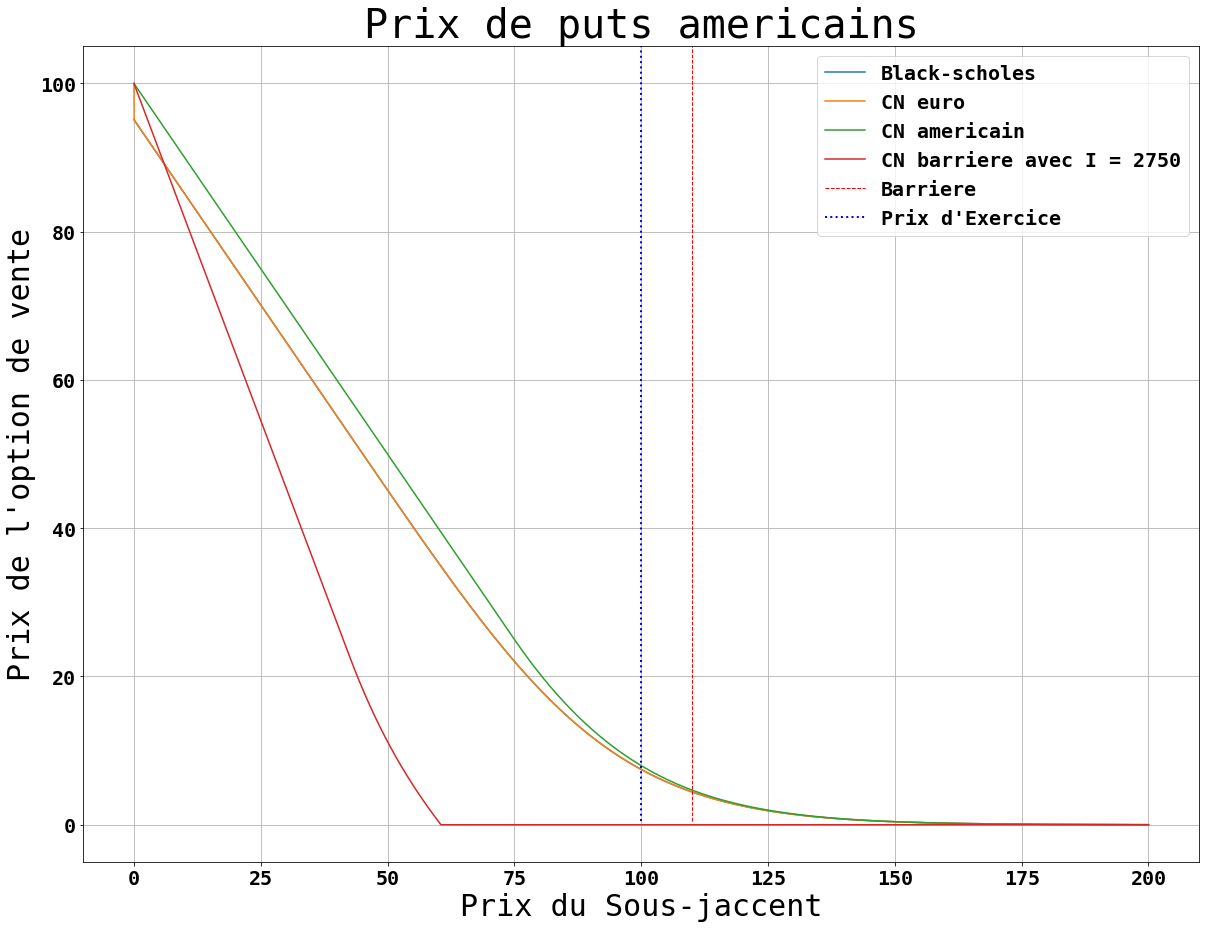

In [529]:
plt.figure(figsize=(20, 15))
plt.plot(S0,BS_euro,S0,CN_euro,S0,CN_amer,S0,CN_bar1)
plt.axvline(x=bar_TP,ymin =0.05, color='r', linestyle='--',label = 'Barriere', linewidth = 1)
plt.axvline(x=SK_TP,ymin =0.05 ,color='b', linestyle=':', label = "Prix d'Exercice", linewidth = 2)
plt.grid()
plt.legend(["Black-scholes", "CN euro","CN americain","CN barriere avec I = 2750",'Barriere',"Prix d'Exercice"])
plt.xlabel("Prix du Sous-jaccent",color = "black", size = 30,fontname = 'monospace')
plt.ylabel("Prix de l'option de vente", color = "black", size = 30,fontname = 'monospace')
plt.title("Prix de puts americains", color = "black", size = 40,fontname = 'monospace')

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)


Graphique avec I = 5000 pour tout les put

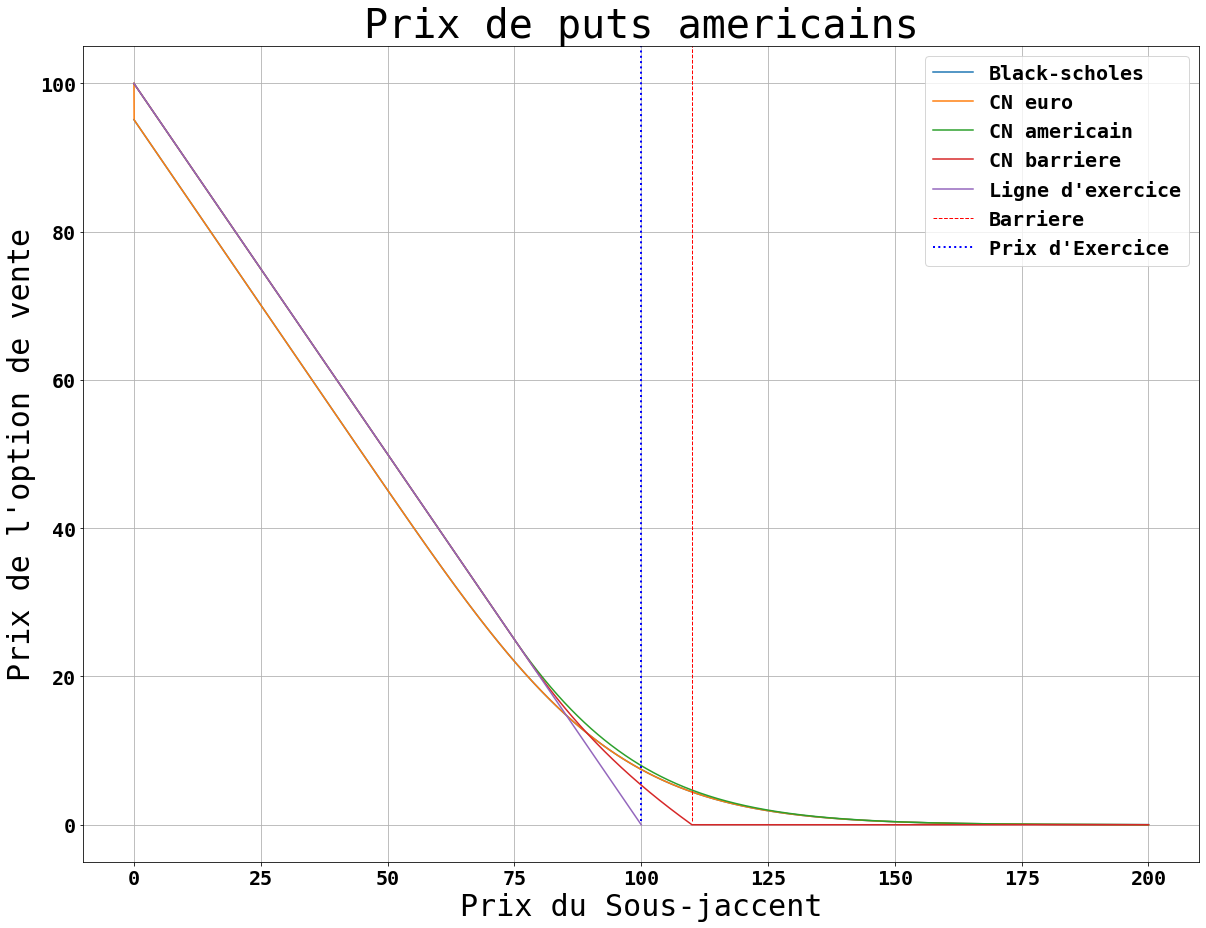

In [521]:
x = [0,100]
y = [100,0]
plt.figure(figsize=(20, 15))
plt.plot(S0,BS_euro,S0,CN_euro,S0,CN_amer,S0,CN_bar,x,y)
plt.axvline(x=bar_TP,ymin =0.05, color='r', linestyle='--',label = 'Barriere', linewidth = 1)
plt.axvline(x=SK_TP,ymin =0.05 ,color='b', linestyle=':', label = "Prix d'Exercice", linewidth = 2)
plt.grid()
plt.legend(["Black-scholes", "CN euro","CN americain","CN barriere","Ligne d'exercice",'Barriere',"Prix d'Exercice"])
plt.xlabel("Prix du Sous-jaccent",color = "black", size = 30,fontname = 'monospace')
plt.ylabel("Prix de l'option de vente", color = "black", size = 30,fontname = 'monospace')
plt.title("Prix de puts americains", color = "black", size = 40,fontname = 'monospace')

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)  


Meme Graphique que précédemment, mais zoomé entre 75 et 125

(75.0, 125.0)

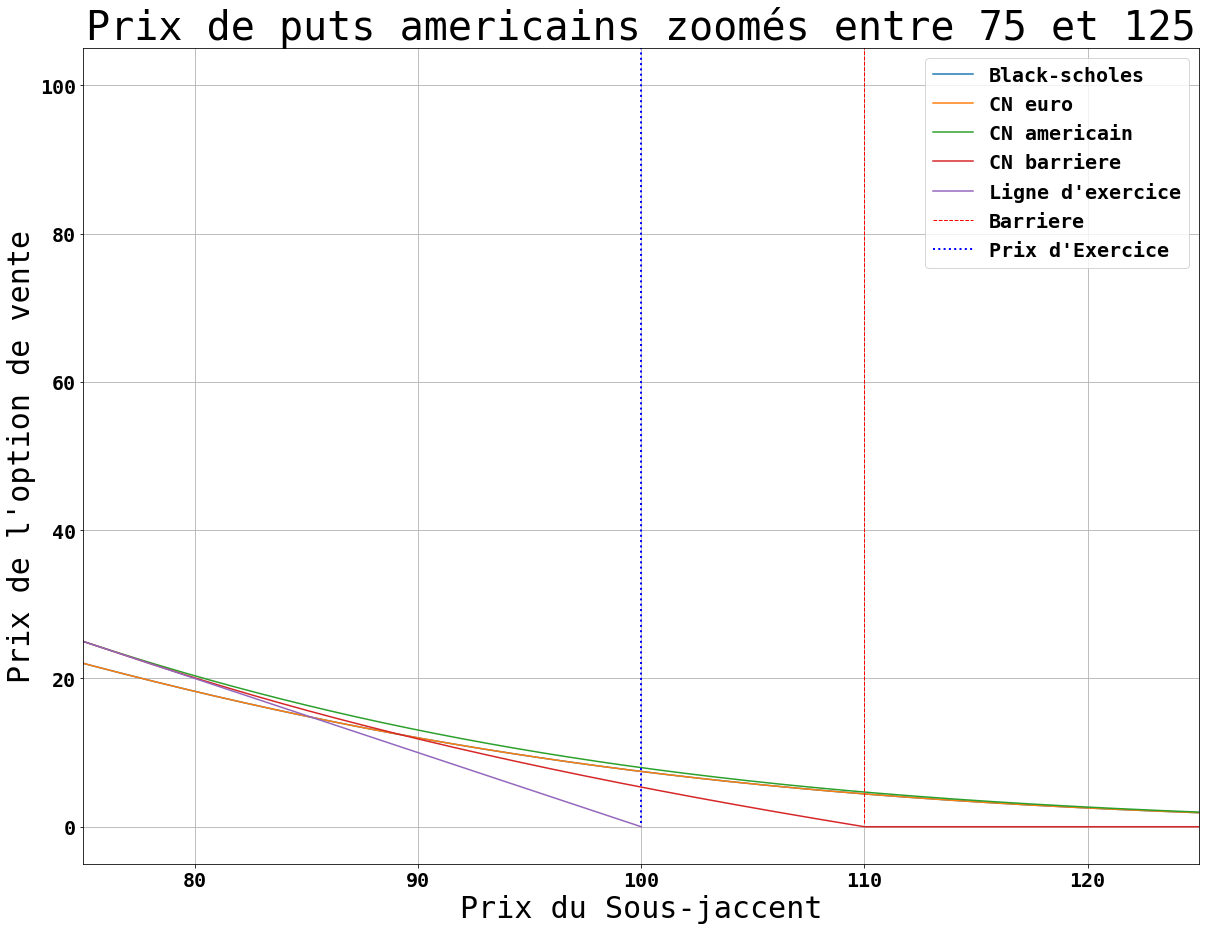

In [522]:
plt.figure(figsize=(20, 15))
plt.plot(S0,BS_euro,S0,CN_euro,S0,CN_amer,S0,CN_bar,x,y)
plt.axvline(x=bar_TP,ymin =0.05, color='r', linestyle='--',label = 'Barriere', linewidth = 1)
plt.axvline(x=SK_TP,ymin =0.05 ,color='b', linestyle=':', label = "Prix d'Exercice", linewidth = 2)
plt.grid()
plt.legend(["Black-scholes", "CN euro","CN americain","CN barriere","Ligne d'exercice",'Barriere',"Prix d'Exercice"])
plt.xlabel("Prix du Sous-jaccent",color = "black", size = 30,fontname = 'monospace')
plt.ylabel("Prix de l'option de vente", color = "black", size = 30,fontname = 'monospace')
plt.title("Prix de puts americains zoomés entre 75 et 125", color = "black", size = 40,fontname = 'monospace')
plt.xlim([75, 125])

Question 4 

Les deux frontières d'exercice ont des trajectoires similaires jusqu'au environ de t = 0.8 (maturité résiduelle = 0.2) , ou elles se dissocient.  A partir de cette valeur de maturité résiduelle, la frontière du put vanille est inférieure à celle du put barrière, cette dernière démontrant plus de convexité que celle du put vanille. Les deux frontière convergent asymptotiquement vers une valeur de S = 75 à mesure qu'on s'éloigne de l'échéance. à t = 0, la frontière du put vanille semble toucher S = 75, et le put barrière S = 77.5.

Autrement dit, lorsque la maturité résiduelle est encore élevée, à savoir quand les puts ont
potentiellement encore du temps avant l'échéance, on constate que la frontiére
d'exercice relative à un put américain up and out est plus élevée que celle
d'un put américain. Cela s’explique par le  faite que vu que les valeurs de
continuation sont plus faibles pour le put up and out, les valeurs de
sous-jacent pour lesquelles on choisit d'exercer seront plus élevées que celles
pour un put américain.
Ensuite, plus on se rapproche de l'échéance et que la valeur du sous-jacent se
rapproche de la barrière, plus il devient moins avantageux de garder le put up
and out en raison de la barrière qui désactive  notre option.

In [496]:
matres = 1-np.linspace(0,1,K)
front_amer = np.flip(grille_amer[1])
front_bar = np.flip(grille_bar[1])

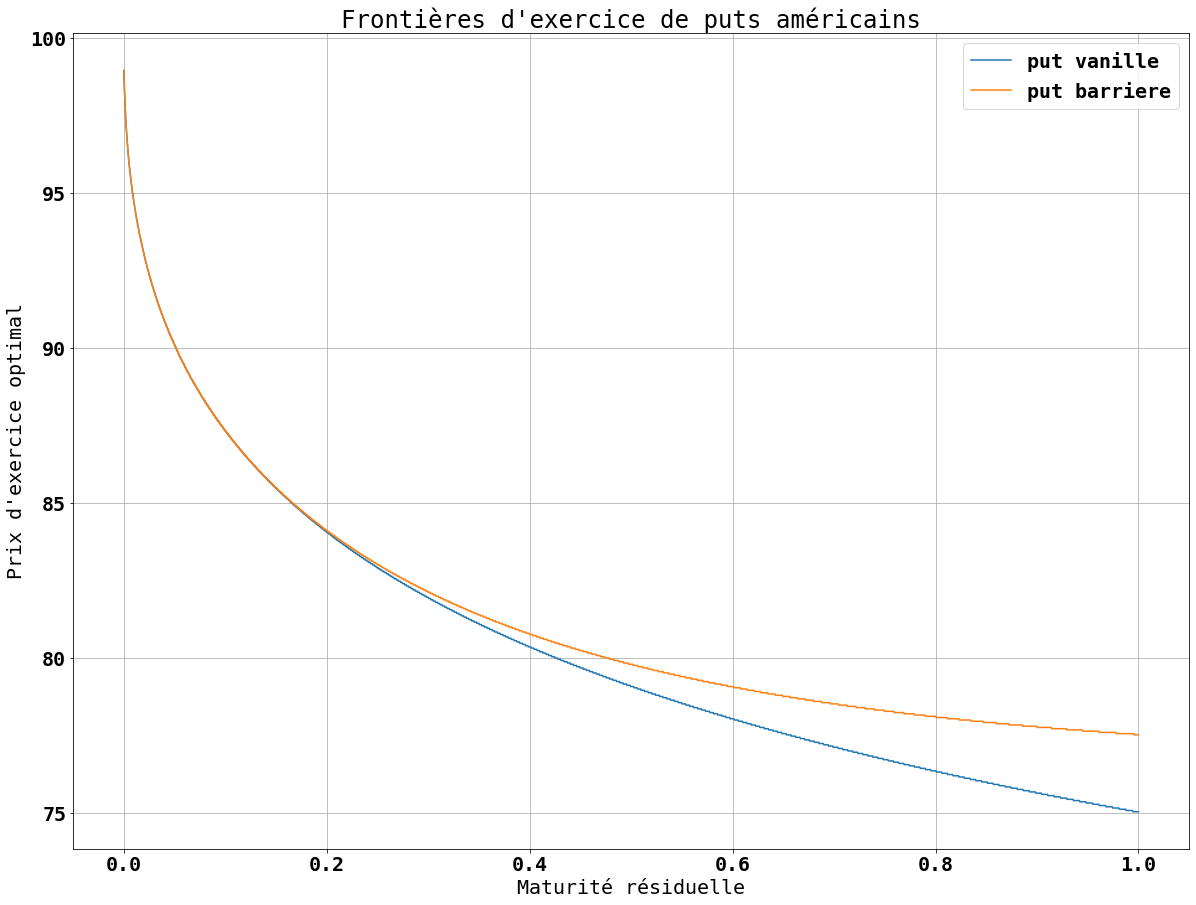

In [481]:
plt.figure(figsize=(20, 15))
plt.plot(matres,front_amer,matres,front_bar)
plt.legend(["put vanille", "put barriere"])
plt.xlabel("Maturité résiduelle",color = "black", size = 30,fontname = 'monospace')
plt.ylabel("Prix d'exercice optimal",color = "black", size = 30,fontname = 'monospace')
plt.title("Frontières d'exercice de puts américains",color = "black", size = 40,fontname = 'monospace')
plt.grid()

Question 5

Les trois figures ci-dessous nous montrent le gamma du put vanille européen, calculé selon la formule analytique de Black-Scholes et selon la grille trouvée par Crank-Nicholson.La première figure nous montre les valeurs du gamma pour les noeuds de 2 à I-1. La première chose que nous remarquons est la différence flagrante d'échelle. Le gamma Black-scholes a une forme de cloche aplatie, tandis que le gamma CN semble ne prendre qu'une seule valeur. Le gamma CN a des valeurs extremes dans les zones de noeuds terminaux, ce qui rééchélonne complètement le graphique. La deuxième figure nous montre ces deux gamma, mais avec chacun leur axe vertical. On peut alors ici  bien distinguer la forme en cloche du gamma BS. La troisième figure quant à elle, nous montre la meme chose que la figure 1, cette fois-ci pour les noeuds 2 à I-6. Nous observons enfin ici le gamma CN dans sa forme véritable de cloche qui, pour les valeurs du sous-jaccent de 2 à I-6, est indistingable du gamma BS. Les valeurs aberrantes du gamma aproximé par CN observées pour les noeuds extremes (region deep in the money et/ou deep out of the money ) sont attribuables aux hypothèses de noeuds terminaux effectuées, ainsi qu'à la méthode numérique de convergence utilisée, qui vient elle aussi avec ses approximations et ses hypothèses. Le gamma Black-Scholes quant à lui résulte d'une formule analytique, raison de la précision de sa forme en cloche. La forme en cloche de la cloche reflète le fait que le gamma est directement proportionnel à la densité de la loi gaussienne: 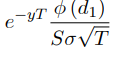

Enfin, il est intéréssant de noter que la méthode de Crank-Nicolson est universellement connue dans le monde de la finance pour donner de mauvaises approximations des coefficients grecs, particulièrement autour du prix d'exercice et des extremités verticales de la grille. Des solutions intéréssantes explorées dans la littérature scientifique sont par exemple la méthode "Exponentialy fitted scheme" et la méthode de Keller.

In [482]:
Sg = S0[1:I]

gamma_euro = [(CN_euro[i-1] - 2*CN_euro[i] + CN_euro[i+1])/(dS**2) for i in range(1,I)]
gamma_amer = [(CN_amer[i-1] - 2*CN_amer[i] + CN_amer[i+1])/(dS**2) for i in range(1,I)]
gamma_bar  = [(CN_bar[i-1] - 2*CN_bar[i] + CN_bar[i+1])/(dS**2) for i in range(1,I)]

gamma_BS = [gammaBS(i,SK_TP,T_TP,sigma_TP,r_TP) for i in Sg]

Gamma du put vanille européen calculé par Black-Scholes et par Crank-Nicolson pour les noeuds 2 à I-1

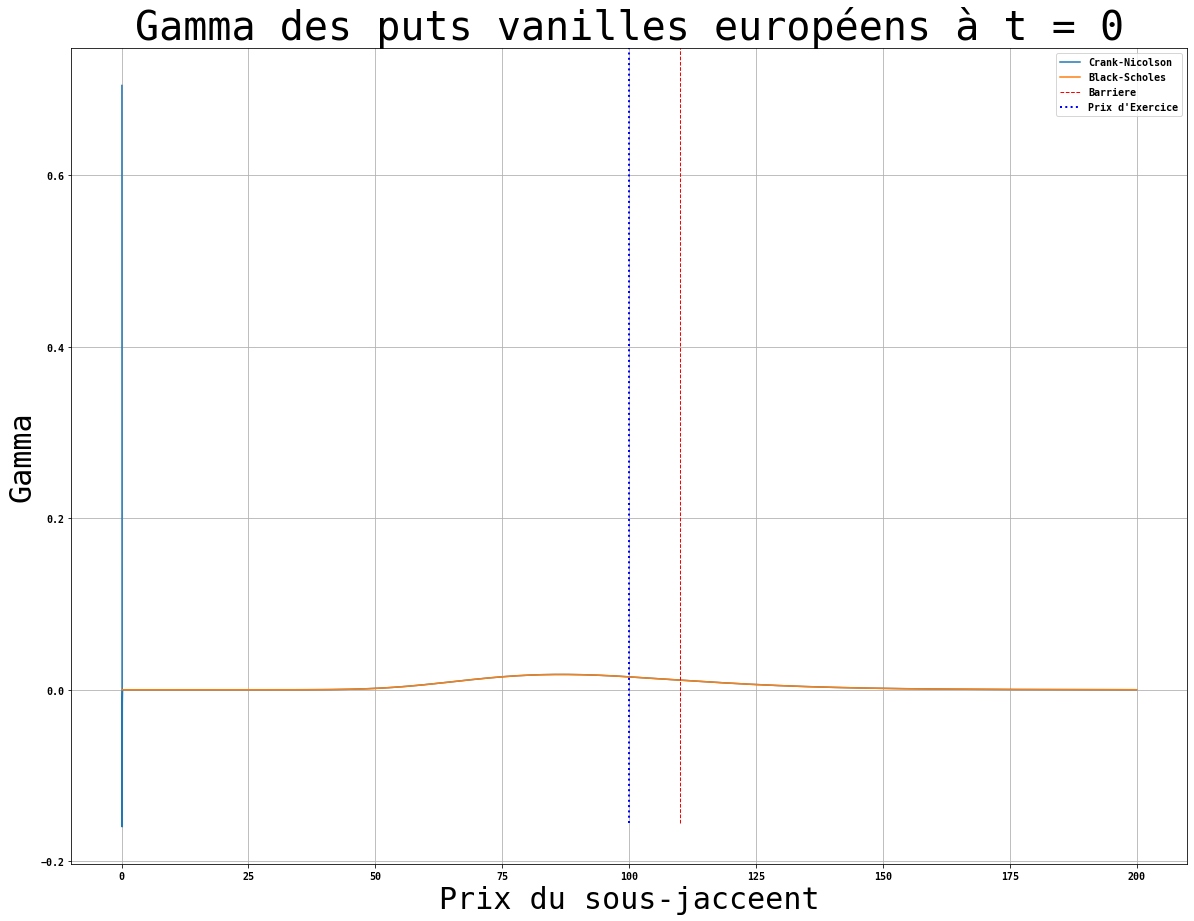

In [562]:
plt.figure(figsize=(20, 15))
plt.plot(Sg[:-1],gamma_euro[:-1],Sg[:-1],gamma_BS[:-1])
plt.axvline(x=bar_TP,ymin =0.05, color='r', linestyle='--', linewidth = 1)
plt.axvline(x=SK_TP,ymin =0.05 ,color='b', linestyle=':',  linewidth = 2)
plt.legend(["Crank-Nicolson", "Black-Scholes",'Barriere',"Prix d'Exercice"])
plt.xlabel("Prix du sous-jacceent",color = "black", size = 30,fontname = 'monospace')
plt.ylabel("Gamma",color = "black", size = 30,fontname = 'monospace')
plt.title("Gamma des puts vanilles européens à t = 0",color = "black", size = 40,fontname = 'monospace')
plt.grid()

Meme graphe que celui du haut, mais avec un axe vertical différent pour chaque gamma.

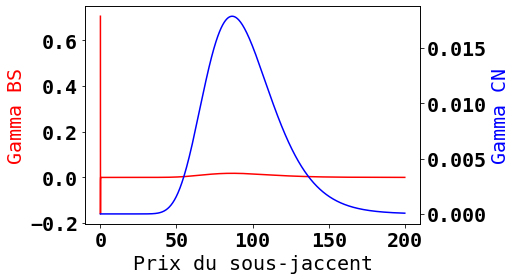

In [527]:
fig,ax = plt.subplots()
# make a plot
ax.plot(Sg[:-1],gamma_euro[:-1], color="red")
# set x-axis label
ax.set_xlabel("Prix du sous-jaccent",fontsize=20)
# set y-axis label
ax.set_ylabel("Gamma BS",color="red",fontsize=20)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(Sg[:-1],gamma_BS[:-1],color="blue")
ax2.set_ylabel("Gamma CN",color="blue",fontsize=20)
plt.show()




Meme graphique, mais en excluant les gamma des noeuds I-5 à I+1 car ces derniers étant trop deep in the money, leurs gamma recalibraient tout le graphique en fonction de leur valeur extremes, nous empechant de visualiser la forme convexité du gamma par rapport au sous-jaccent.

Gamma du put vanille européen calculé par Black-Scholes et par Crank-Nicolson pour les noeuds 2 à I-1

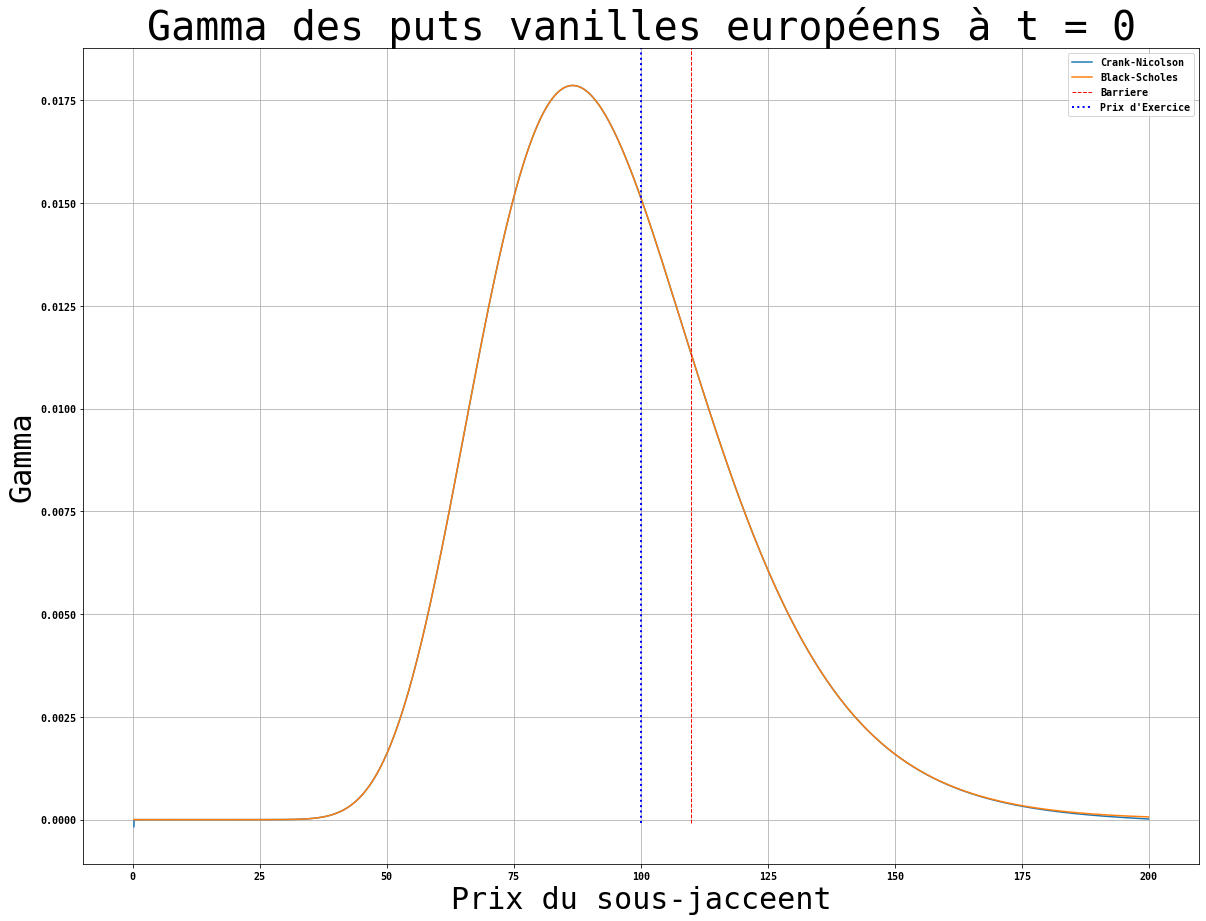

In [561]:
plt.figure(figsize=(20, 15))
plt.plot(Sg[:-5],gamma_euro[:-5],Sg[:-5],gamma_BS[:-5])
plt.axvline(x=bar_TP,ymin =0.05, color='r', linestyle='--', linewidth = 1)
plt.axvline(x=SK_TP,ymin =0.05 ,color='b', linestyle=':', linewidth = 2)
plt.legend(["Crank-Nicolson", "Black-Scholes",'Barriere',"Prix d'Exercice"])
plt.xlabel("Prix du sous-jacceent",color = "black", size = 30,fontname = 'monospace')
plt.ylabel("Gamma",color = "black", size = 30,fontname = 'monospace')
plt.title("Gamma des puts vanilles européens à t = 0",color = "black", size = 40,fontname = 'monospace')
plt.grid()

Question 6 - Gamma des put americains

Les gammas pour les put américains vanille et barrière ont, pour toute les valeurs de S, des valeurs identiques, excepté autour de la barrière, entre 75 et 125. Un zoom de la figure dans la zone entourant la barrière nous permet de voir que, pour les deux gamma, nous avons un léger pic des valeurs du gamma autour de S = 75, puis un pic très prononcé qui rééchélonne tout le graphique (valeur du pic est d'un ordre de magnitude différent du reste des gamma) à 110 pour le put barrière, et autour de 115 pour le put vanille. Le gamma du put barrière atteint toujours son pic bien avant celui du put vanille. 

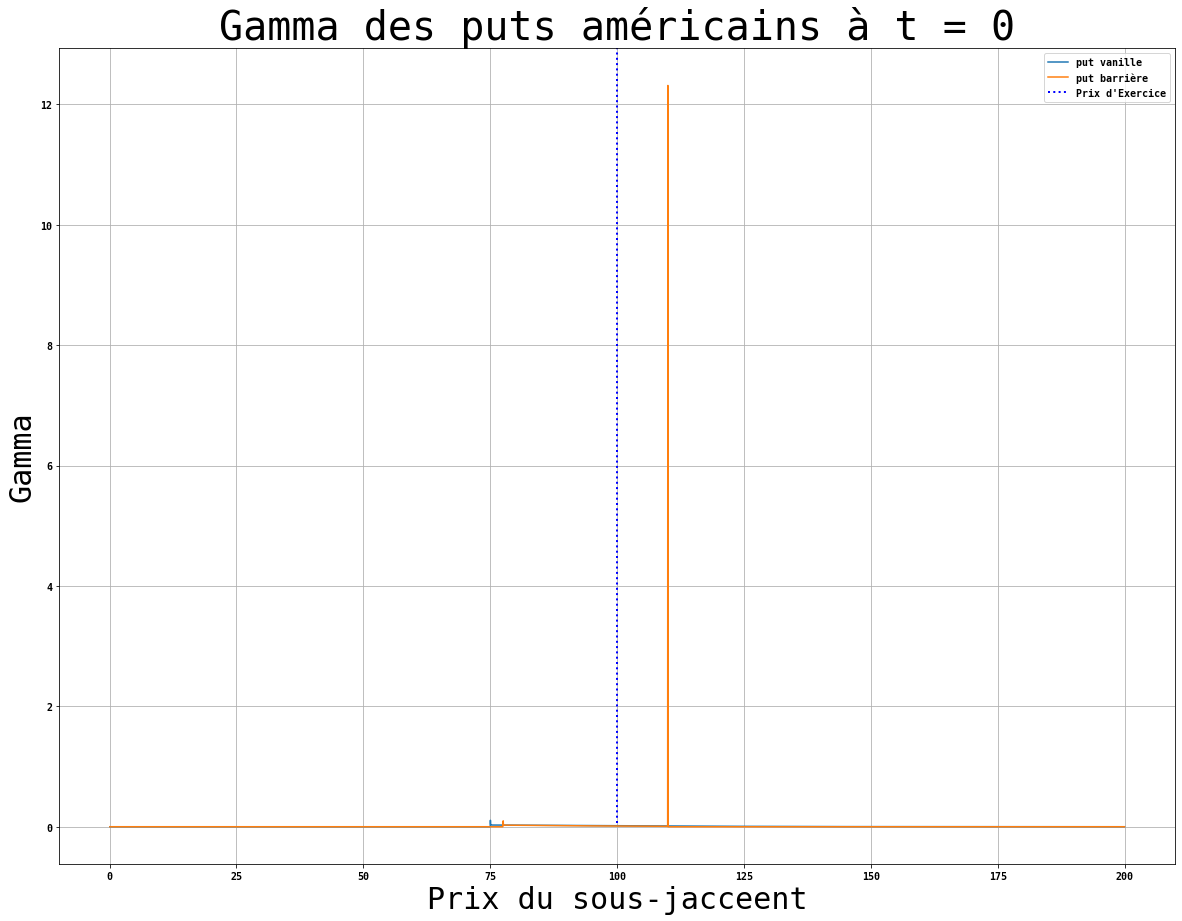

In [559]:
plt.figure(figsize=(20, 15))
plt.plot(Sg[:-1],gamma_amer[:-1],Sg[:-1],gamma_bar[:-1])

plt.axvline(x=SK_TP,ymin =0.05 ,color='b', linestyle=':', linewidth = 2)
plt.legend(["put vanille", "put barrière","Prix d'Exercice"])
plt.xlabel("Prix du sous-jacceent",color = "black", size = 30,fontname = 'monospace')
plt.ylabel("Gamma",color = "black", size = 30,fontname = 'monospace')
plt.title("Gamma des puts américains à t = 0",color = "black", size = 40,fontname = 'monospace')
plt.grid()

Meme graphique que précédemment, zoomé vers la zone de la barrière et du strike.

(0.0001, 0.06)

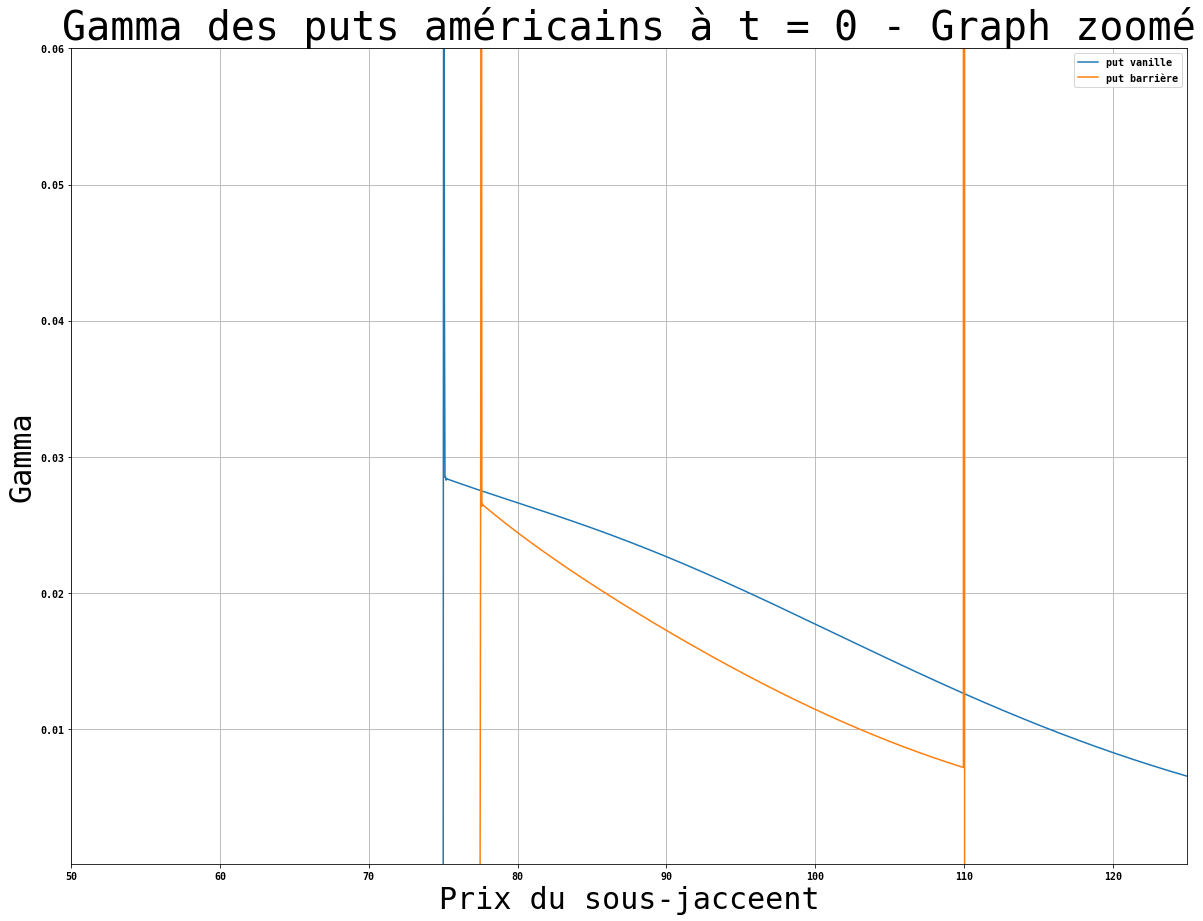

In [510]:
plt.figure(figsize=(20, 15))
plt.plot(Sg[:-1],gamma_amer[:-1],Sg[:-1],gamma_bar[:-1])
plt.legend(["put vanille", "put barrière"])
plt.xlabel("Prix du sous-jacceent",color = "black", size = 30,fontname = 'monospace')
plt.ylabel("Gamma",color = "black", size = 30,fontname = 'monospace')
plt.title("Gamma des puts américains à t = 0 - Graph zoomé",color = "black", size = 40,fontname = 'monospace')
plt.grid()
plt.xlim([50, 130])
plt.ylim([0.0001, 0.06])

Question 7 

La première chose que nous avons faite afin d'obtenir ces résultats était d'importer la trajectoire quotidienne des prix du sous-jaccent à partir de DropBox. Nous avons ensuite créé un vecteur de temps qui passe, entre 0 et 1 an avec des pas de temps d'un dixième de journée (1/3650). Nous avons après cela procédé à l'estimation de la frontière d'exercice en utilisant l'approximation de Carl-Jarrow-Myneny. Afin d'avoir la trajectoire du prix du put sans exercice, nous avons calculé la valeur du put à chaque instant en fonction de la valeur de l'action a cet  instant et de la maturité résiduelle.Nous avons pour cela utilisé la formule analytique de Black-Scholes. Afin d'avoir la trajectoire du prix du put si on l'exerce, nous avons trouvé le premier instant ou il devient optimal d'exercer(en fonction de la frontiere d'exercice et du prix de l'action) et considéré le prix du put constant à partir de cet instant jusqu'à la fin.

L'instant optimal d'exercice est le 33_ème jour de la trajectoire, soit l'indice 339. Cet instant correspond à celui ou la frontière d'exercice touche la trajectoire du prix de l'action. Les deux trajectoires de put obtenues sont identique jusqu'au 338ème jour ou le deuxième put est exercé, et à partir duquel la trajectoire du put non-exercé amorce une décroissance.

In [501]:

#récupération des données du stock par le lien DropBox
Stock= np.array(pandas.read_csv('https://www.dropbox.com/s/2lwtedqyhbnl8dg/S.csv?dl=1',header=None))[0]
n = len(Stock)
matres = 1 - np.arange(0,1,1/n) # vecteur de maturité résiduelle
t = np.flip(matres) #vecteur de temps qui passe

#Calcul de la frontière d'exercice en utilisant l'approximation de Carl-Jarrow-Myneny
frontier = [Bt(100,0.05,0.25,tau) for tau in matres]


Put1 = [BS(Stock[i],100,matres[i],0.25,0.05,"p") for i in range(0,n)] #Trajectoire du put sans exercice anticipé

index = np.where(abs(Stock - frontier) == min(abs(Stock - frontier)))[0][0] # index du premier instant ou il est optimal d'exercer

#Trajectoire du put avec exercice anticipé au momen optimal
Put2 = [BS(Stock[i],100,matres[i],0.25,0.05,"p") for i in range(0,index + 1)] 

Put2 = np.concatenate((Put2,np.full(n-len(Put2),Put2[-1])))







<Figure size 1440x1080 with 0 Axes>

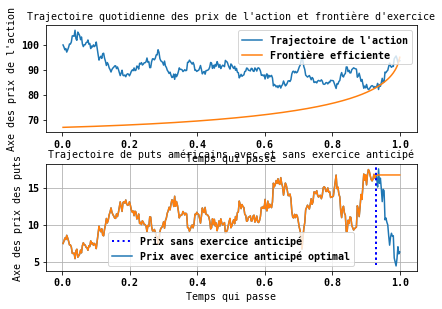

In [556]:
plt.figure(figsize=(20, 15))
fig,ax=plt.subplots(nrows=2,ncols=1)
ax0,ax1=ax.flatten()
fig.tight_layout()
plt.grid()


ax0.plot(t,Stock,t,frontier)
plt.axvline(x=t[index],ymin =0.05 ,color='b', linestyle=':', linewidth = 2)
ax0.legend(["Trajectoire de l'action", "Frontière efficiente"])
ax0.set_xlabel("Temps qui passe")
ax0.set_ylabel("Axe des prix de l'action")
ax0.set_title("Trajectoire quotidienne des prix de l'action et frontière d'exercice",size = 10)



ax1.plot(t,Put1,t,Put2)
plt.axvline(x=t[index],ymin =0.05 ,color='b', linestyle=':', linewidth = 2)
ax1.legend(["Prix sans exercice anticipé", "Prix avec exercice anticipé optimal"])
ax1.set_xlabel("Temps qui passe",size = 10)
ax1.set_ylabel("Axe des prix des puts",size = 10)
ax1.set_title("Trajectoire de puts américains avec et sans exercice anticipé", size = 10)




font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

